# Charged Patchy Particle Model
_Alexei Abrikossov and Mikael Lund, December 2016_

In this Notebook we setup an MC simulation to calculate the interaction free energy between a pair
of CPPM's.

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from scipy import integrate
import pandas as pd
import os.path, os, sys, json, shutil, glob
from pathlib import Path
import pickle
from sys import stdout
from math import exp, sqrt
#import mdtraj as md

#mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

#plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plt.rcParams.update({'font.size': 16, 'figure.figsize': [6.0, 5.0]})
#plt.rc('text', usetex=True)

try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

### Download and compile the MC software Faunus

In [531]:
%%bash -s "$workdir"
module add GCC/6.2.0-2.27
module add CMake
cd $1

if [ ! -d "faunus" ]; then
  git clone https://github.com/mlund/faunus.git
  cd faunus
  git checkout af18cc5a3bb8df32bb50c1ad972abf3e67599a6b
else
  cd faunus
fi

CXX=/sw/easybuild/software/Core/GCCcore/6.2.0/bin/g++ CC=/sw/easybuild/software/Core/GCCcore/6.2.0/bin/gcc cmake . -DCMAKE_BUILD_TYPE=Release -DMYPLAYGROUND=/lunarc/nobackup/users/mikael/github/cppm/mc #&>/dev/null
make twobody twobody-cuboid -j4
cd $1

-- Could NOT find Doxygen (missing:  DOXYGEN_EXECUTABLE) 
-- Configuring done
-- Generating done
-- Build files have been written to: /lunarc/nobackup/users/mikael/github/cppm/faunus
[ 33%] Built target xdrfile
[ 83%] Built target libfaunus
Scanning dependencies of target twobody
[ 91%] Building CXX object /lunarc/nobackup/users/mikael/github/cppm/mc/CMakeFiles/twobody.dir/twobody.cpp.o
[100%] Linking CXX executable twobody
[100%] Built target twobody
[ 33%] Built target xdrfile
[ 83%] Built target libfaunus
Scanning dependencies of target twobody-cuboid
[ 91%] Building CXX object /lunarc/nobackup/users/mikael/github/cppm/mc/CMakeFiles/twobody-cuboid.dir/twobody.cpp.o
[100%] Linking CXX executable twobody-cuboid
[100%] Built target twobody-cuboid


......................................................................
  Faunus is running in Release mode recommended for production runs.
  For setting up simulations it is HIGHLY recommended to use Debug
  mode to enable run-time checks and assertions:

  -DCMAKE_BUILD_TYPE=RelWithDebInfo
**********************************************************************



### Function for generating JSON input file for Faunus

In [269]:
import os.path, os, sys, json, shutil
from pathlib import Path

def mkinput(ions):
    js = {
          "energy" : {
            "nonbonded" : {
              "coulomb" : { "epsr" : 78.7 },
              "lj" : {
                    "__custom__" : {
                        "MP Na": dict(sigma=(40+2)/2.0, eps=0.02479),
                        "MP La": dict(sigma=(40+2)/2.0, eps=0.02479),
                        "MP Cl": dict(sigma=(40+2)/2.0, eps=0.02479),
                        "NP La": dict(sigma=3.0, eps=1.6),
                      }
                    }
            },

            "cmconstrain" : {
              "0sphere 1sphere" : { "mindist": 0, "maxdist": 99 }
              }
            },

          "atomlist" : {
            "UP":  dict(q=0,  sigma=4.0, eps=ljeps, mw=1e-3),
            "NP":  dict(q=-1, sigma=4.0, eps=ljeps, mw=1e-3),
            "PP":  dict(q=1,  sigma=4.0, eps=ljeps, mw=1e-3),
            "MP":  dict(q=0,  sigma=40,  eps=ljeps, mw=1e6),
            "Na":  dict(q=1,  sigma=4.0, eps=ljeps, mw=1e-3, dp=50),
            "La":  dict(q=3,  sigma=1.0, eps=ljeps, mw=1e-3, dp=10),
            "PO4": dict(q=-3,  sigma=1.0, eps=ljeps, mw=1e-3, dp=10),
            "Cl":  dict(q=-1, sigma=4.0, eps=ljeps, mw=1e-3, dp=50)
              },

          "moleculelist": {
              "0sphere":  { "structure":xyzfile, "Ninit":1, "insdir":"0 0 0", "insoffset":"0 0 "+str(offset)},
              "1sphere":  { "structure":xyzfile, "Ninit":1, "insdir":"0 0 0", "insoffset":"0 0 -"+str(offset)}
              },

          "moves" : {
              "moltransrot2body" : {
                "0sphere" : { "dp":dp, "dprot":0.5 }, 
                "1sphere" : { "dp":dp, "dprot":0.5 } 
                }
          },
          "analysis" : {
            "pqrfile" : { "file": "confout.pqr"  },
            "statefile" : { "file": "state" },
            "xtcfile" : { "file": "traj.xtc", "nstep": nstep_xtc },
            "meanforce" : { "nstep": nstep_force, "groups": [0,1] },
            "chargemultipole" : {"nstep":1000, "mollist":["0sphere", "1sphere"]},
            "multipoledistribution" :
                { "file": "multipole.dat", "nstep":10, "groups":["0sphere", "1sphere"] }
          },

          "system" : {
              "temperature" : 298.15,
              "cylinder" : { "length" : cyllen, "radius" : cylradius },
              "mcloop"   : { "macro" : 10, "micro" : micro }
              }
          }
    
    for name, N in ions.items():
        if N>0:
            js['moleculelist'][name] = dict(Ninit=N, atomic=True, atoms=name)
            if not 'atomtranslate' in js['moves']:
                js['moves']['atomtranslate'] = {}
            js['moves']['atomtranslate'][name] = dict(peratom=True)

    with open('twobody.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))
        
def volume():
    return np.pi*cylradius**2 * cyllen

cylradius=55 # cylinder radius (angstrom)
cyllen=200   # cylinder length (angstrom)
ljeps=2.479 # LJ epsilon (kj/mol)
offset=40    # initial COM-COM separation (angstrom)
maxdist=500  # maximum allowed COM-COM distance (angstrom)
dp=4         # COM translational displacement parameter (angstrom)
nstep_xtc=0  # frequency for saving frames to xtc trajectory file
nstep_force=0# frequency for direct force calculation

In [552]:
def M2N(molarity):
    ''' Convert mol/l to nearest integer number of particles in cylinder '''
    return int( round( molarity * volume() * 1e-27 * 6.022e23 ) )

R_range = np.arange(39, 80, 0.5) # separation space to scan (angstrom)
param = pd.DataFrame({
    'Neutral' :
        dict(
            charge=0, xyzfile=workdir+'/mc/sphere-neutral-reduced.xyz',
            R=R_range, label=r'Neutral', color='black',
            cs=0, ions = dict(Na=0), ljeps=[0.2479]
        ),

    # P00 1:1 salt
    'P00-1:1-10mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            R=R_range, label=r'$P_0^0$ 10 mM 1:1', color='blue',
            cs=0.010, ions = dict(Na=16+M2N(0.010), Cl=M2N(0.010)), ljeps=[2.479]
        ),
    'P00-1:1-10mM-point' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-point.aam',
            R=R_range, label=r'$\tilde{P}_0^0$ 10 mM 1:1', color='blue',
            cs=0.010, ions = dict(Na=16+M2N(0.010), Cl=M2N(0.010)), ljeps=[2.479]
        ),
    'P00-1:1-50mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            R=R_range, label=r'$P_0^0$ 50 mM 1:1', color='blue',
            cs=0.05, ions = dict(Na=16+M2N(0.05), Cl=M2N(0.05)), ljeps=[2.479]
        ),
    'P00-1:1-50mM-point' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-point.aam',
            R=R_range, label=r'$\tilde{P}_0^0$ 50 mM 1:1', color='blue',
            cs=0.010, ions = dict(Na=16+M2N(0.050), Cl=M2N(0.050)), ljeps=[2.479]
        ),
    'P00-1:1-100mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            R=R_range, label=r'$P_0^0$ 100 mM 1:1', color='blue',
            cs=0.1, ions = dict(Na=16+M2N(0.1), Cl=M2N(0.1)), ljeps=[2.479]
        ),
    
    # P00 3:1 salt
    'P00-3:1-5mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            R=R_range, label=r'$P_0^0$ 5 mM 3:1', color='blue',
            cs=0.005, ions = dict(Na=16, La=M2N(0.005), Cl=3*M2N(0.005)), ljeps=[2.479]
        ),
    'P00-3:1-10mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            R=R_range, label=r'$P_0^0$ 10 mM 3:1', color='blue',
            cs=0.010, ions = dict(Na=16, La=M2N(0.010), Cl=3*M2N(0.010)), ljeps=[2.479]
        ),
    'P00-3:1-50mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            R=R_range, label=r'$P_0^0$ 50 mM 3:1', color='blue',
            cs=0.05, ions = dict(Na=16, La=M2N(0.05), Cl=3*M2N(0.05)), ljeps=[2.479]
        ),
    
    # P00 1:3 salt
    'P00-1:3-5mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P00-reduced.xyz',
            R=R_range, label=r'$P_0^0$ 5 mM 1:3', color='blue',
            cs=0.005, ions = dict(PO4=M2N(0.005), Na=16+3*M2N(0.005)), ljeps=[2.479]
        ),
    
    # P18 1:1 salt
    'P18-1:1-10mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            R=R_range, label=r'$P_8^1$ 10 mM 1:1', color='blue',
            cs=0.010, ions = dict(Na=16+M2N(0.010), Cl=M2N(0.010)), ljeps=[2.479]
        ),
    'P18-1:1-10mM-point' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-point.aam',
            R=R_range, label=r'$\tilde{P}_8^1$ 10 mM 1:1', color='blue',
            cs=0.010, ions = dict(Na=16+M2N(0.010), Cl=M2N(0.010)), ljeps=[2.479]
        ),
    'P18-1:1-50mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            R=R_range, label=r'$P_8^1$ (50 mM 1:1)', color='blue',
            cs=0.05, ions = dict(Na=16+M2N(0.05), Cl=M2N(0.05)), ljeps=[2.479]
        ),
    'P18-1:1-50mM-point' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-point.aam',
            R=R_range, label=r'$\tilde{P}_8^1$ 50 mM 1:1', color='blue',
            cs=0.050, ions = dict(Na=16+M2N(0.050), Cl=M2N(0.050)), ljeps=[2.479]
        ),
    'P18-1:1-100mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            R=R_range, label=r'$P_8^1$ 100 mM 1:1', color='blue',
            cs=0.1, ions = dict(Na=16+M2N(0.1), Cl=M2N(0.1)), ljeps=[2.479]
        ),
    'P18-1:1-100mM-point' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-point.aam',
            R=R_range, label=r'$\tilde{P}_8^1$ 100 mM 1:1', color='blue',
            cs=0.10, ions = dict(Na=16+M2N(0.10), Cl=M2N(0.10)), ljeps=[2.479]
        ),
    
    # P18 3:1 salt
    'P18-3:1-10mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            R=R_range, label=r'$P_8^1$ 10 mM 3:1', color='blue',
            cs=0.010, ions = dict(Na=16, La=M2N(0.010), Cl=3*M2N(0.010)), ljeps=[2.479]
        ),
    'P18-3:1-5mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            R=R_range, label=r'$P_8^1$ 5 mM 3:1', color='blue',
            cs=0.005, ions = dict(Na=16, La=M2N(0.005), Cl=3*M2N(0.005)), ljeps=[2.479]
        ),
    'P18-3:1-50mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            R=R_range, label=r'$P_8^1$ (50 mM 3:1)', color='blue',
            cs=0.05, ions = dict(Na=16, La=M2N(0.05), Cl=3*M2N(0.05)), ljeps=[2.479]
        ),
    
    # P28 3:1 salt
    'P28-3:1-10mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P28-reduced.xyz',
            R=R_range, label=r'$P_8^2$ 10 mM 3:1', color='blue',
            cs=0.010, ions = dict(Na=16, La=M2N(0.010), Cl=3*M2N(0.010)), ljeps=[2.479]
        ),
    'P28-3:1-5mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P28-reduced.xyz',
            R=R_range, label=r'$P_8^2$ 5 mM 3:1', color='blue',
            cs=0.005, ions = dict(Na=16, La=M2N(0.005), Cl=3*M2N(0.005)), ljeps=[2.479]
        ),
    
    # P18 1:3 salt (i.e. Na3PO4)
    'P18-1:3-10mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            R=R_range, label=r'$P_8^1$ 10 mM 1:3', color='blue',
            cs=0.010, ions = dict(PO4=M2N(0.010), Na=16+3*M2N(0.010)), ljeps=[2.479]
        ),
    'P18-1:3-5mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P18-reduced.xyz',
            R=R_range, label=r'$P_8^1$ 5 mM 1:3', color='blue',
            cs=0.005, ions = dict(PO4=M2N(0.005), Na=16+3*M2N(0.005)), ljeps=[2.479]
        ),

    # P28 1:3 salt (i.e. Na3PO4)
    'P28-1:3-10mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P28-reduced.xyz',
            R=R_range, label=r'$P_8^2$ 10 mM 1:3', color='blue',
            cs=0.010, ions = dict(PO4=M2N(0.010), Na=16+3*M2N(0.010)), ljeps=[2.479]
        ),
    'P28-1:3-5mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P28-reduced.xyz',
            R=R_range, label=r'$P_8^2$ 5 mM 1:3', color='blue',
            cs=0.005, ions = dict(PO4=M2N(0.005), Na=16+3*M2N(0.005)), ljeps=[2.479]
        ),
    
    # P112 1:1 salt
    'P112-1:1-10mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P112-reduced.xyz',
            R=R_range, label=r'$P_{12}^1$ 10 mM 1:1', color='blue',
            cs=0.01, ions = dict(Na=16+M2N(0.01), Cl=M2N(0.01)), ljeps=[2.479]
        ),
    'P112-1:1-100mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P112-reduced.xyz',
            R=R_range, label=r'$P_{12}^1$ 100 mM 1:1', color='blue',
            cs=0.1, ions = dict(Na=16+M2N(0.1), Cl=M2N(0.1)), ljeps=[2.479]
        ),
    
    # P112 3:1 salt
    'P112-3:1-5mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P112-reduced.xyz',
            R=R_range, label=r'$P_{12}^1$ (5 mM 3:1)', color='blue',
            cs=0.005, ions = dict(Na=16, La=M2N(0.005), Cl=3*M2N(0.005)), ljeps=[2.479]
        ),

    # P112 1:3 salt (i.e. Na3PO4)
    'P112-1:3-5mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P112-reduced.xyz',
            R=R_range, label=r'$P_{12}^1$ (5 mM 1:3)', color='blue',
            cs=0.005, ions = dict(PO4=M2N(0.005), Na=16+3*M2N(0.005)), ljeps=[2.479]
        ),
    
    # P116 1:1 salt
    'P116-1:1-10mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P116-reduced.xyz',
            R=R_range, label=r'$P_{16}^1$ 10 mM 1:1', color='blue',
            cs=0.01, ions = dict(Na=16+M2N(0.01), Cl=M2N(0.01)), ljeps=[2.479]
        ),
    'P116-1:1-100mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P116-reduced.xyz',
            R=R_range, label=r'$P_{16}^1$ 100 mM 1:1', color='blue',
            cs=0.1, ions = dict(Na=16+M2N(0.1), Cl=M2N(0.1)), ljeps=[2.479]
        ),
    
    # P116 3:1 salt
    'P116-3:1-5mM' :
        dict(
            charge=-8, xyzfile=workdir+'/mc/sphere-P116-reduced.xyz',
            R=R_range, label=r'$P_{16}^1$ 5 mM 3:1', color='blue',
            cs=0.005, ions = dict(Na=16, La=M2N(0.005), Cl=3*M2N(0.005)), ljeps=[2.479]
        )
    })

param.T

,R,charge,color,cs,ions,label,ljeps,xyzfile
Neutral,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",0,black,0,{'Na': 0},Neutral,[0.2479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-1:1-100mM,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.1,"{'Cl': 114, 'Na': 130}",$P_0^0$ 100 mM 1:1,[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-1:1-10mM,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.01,"{'Cl': 11, 'Na': 27}",$P_0^0$ 10 mM 1:1,[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-1:1-10mM-point,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.01,"{'Cl': 11, 'Na': 27}",$\tilde{P}_0^0$ 10 mM 1:1,[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-1:1-50mM,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.05,"{'Cl': 57, 'Na': 73}",$P_0^0$ 50 mM 1:1,[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-1:1-50mM-point,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.01,"{'Cl': 57, 'Na': 73}",$\tilde{P}_0^0$ 50 mM 1:1,[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-1:3-5mM,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.005,"{'PO4': 6, 'Na': 34}",$P_0^0$ 5 mM 1:3,[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-3:1-10mM,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.01,"{'Cl': 33, 'La': 11, 'Na': 16}",$P_0^0$ 10 mM 3:1,[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-3:1-50mM,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.05,"{'Cl': 171, 'La': 57, 'Na': 16}",$P_0^0$ 50 mM 3:1,[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...
P00-3:1-5mM,"[39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42....",-8,blue,0.005,"{'Cl': 18, 'La': 6, 'Na': 16}",$P_0^0$ 5 mM 3:1,[2.479],/lunarc/nobackup/users/mikael/github/cppm/mc/s...


## Potential of mean force from histogram method

We first calculate the potential of mean force between two neutral spheres by simply sampling the COM-COM distance probability distribution, followed by Boltzmann inversion.

The COM's of the two macromolecules are able to translate along a line which coinsides with the axis of a cylindrical simulation cell with hard boundaries. During simulation, the molecules further rotate around their mass centers. Since the molecules in this way are constrained on a line, there is no need to correct for the increasing volume element normally needed for simulations in free space.

In [115]:
%%writefile $workdir/mc/submit.sh
#!/bin/bash

# This is a submit file, should you be using a cluster. Ignore this if running locally.

#SBATCH -A snic2017-1-48
#SBATCH -N 1
#SBATCH -n 1
#SBATCH -t 100:00:00
../../faunus/src/examples/twobody > out

Overwriting /lunarc/nobackup/users/mikael/github/cppm/mc/submit.sh


In [551]:
%%bash
# kill all jobs
scancel `squeue -h | grep mikael | gawk '{print $1}'`

In [553]:
%cd -q $workdir/mc
for particletype, d in param.items(): # 'P00', 'P18', ...
    
    for eps in d.ljeps: # loop over LJ epsilon values
        
        ljeps = eps
        ionstr = ''
        for ion, N in d.ions.items(): # salt particles
            ionstr = ion+str(N) + ionstr

        directory = particletype

        #directory = 'hist-' + particletype + '-' + ionstr + '-eps' + str(ljeps)
        if not os.path.isdir(directory):
            %mkdir $directory
        if os.path.isdir(directory):
            %cd $directory

            if not os.path.isfile('out'):

                xyzfile=d.xyzfile
                nstep_force=0                # no force calculation
                offset=50/2.0                # COM offset from origo (center of container)
                dp=5                         # protein displacement on line (angstrom)
                micro=1000                    # number of micro steps (equilibration)
                mkinput( d.ions )             # make json input file for faunus

                !rm -fR state                # make sure there's no old state (restart) file
                !OMP_NUM_THREADS=4 nice ../../faunus/src/examples/twobody &> eq # eq. run

                micro=10000000                   # number of micro steps for production
                nstep_xtc=1000                  # save xtc file
                mkinput( d.ions )

                if shutil.which('sbatch') is not None: # run on slurm cluster...
                    !sbatch ../submit.sh
                else:                                  # ...or locally (slow) ?
                    !OMP_NUM_THREADS=4 ../../faunus/src/examples/twobody > out
                    
                nstep_xtc=0                  # disable xtc output for future simulations

            %cd -q ..

print('done.')

/lunarc/nobackup/users/mikael/github/cppm/mc/Neutral
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-1:1-100mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-1:1-10mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-1:1-10mM-point
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-1:1-50mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-1:1-50mM-point
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-1:3-5mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-3:1-10mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-3:1-50mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P00-3:1-5mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P112-1:1-100mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P112-1:1-10mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P112-1:3-5mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P112-3:1-5mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P116-1:1-100mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P116-1:1-10mM
/lunarc/nobackup/users/mikael/github/cppm/mc/P116-3:1-5mM
/l

In [532]:
%cd -q $workdir/mc

from matplotlib.ticker import AutoMinorLocator
def plotmultipole(data, ax, xlim, ljeps=2.479):
    for particletype, d in data.items(): # 'P00', 'P18', ...

        ljeps = ljeps

        ionstr = ''
        for ion, N in d.ions.items(): # loop over all ion conditions
            ionstr = ion+str(N) + ionstr
            
        directory = particletype#'hist-' + particletype + '-' + ionstr + '-eps' + str(ljeps)
        if os.path.isdir(directory):
            %cd -q $directory

            if os.path.isfile('multipole.dat'):
                r,exact,total,ionion,iondip,dipdip,ionquad, mucorr= np.loadtxt('multipole.dat', unpack=True, skiprows=2)
                ax.plot(r, exact, 'ko', alpha=0.6, ms=4, label='exact', markevery=4)
                ax.plot(r, total, 'k-', lw=2, label='multipole sum')
                ax.plot(r, ionion, lw=2, label='ion-ion')
                ax.plot(r, iondip, lw=2, label='ion-dipole')
                ax.plot(r, dipdip, lw=2, label='dipole-dipole')
                ax.plot(r, ionquad, lw=2, label='ion-quadrupole')
                ax.plot(r, mucorr*10, '--', lw=2, ms=4, alpha=0.6, label=r'$10\cdot\langle \mu_1\mu_2\rangle$')
                
                ax.set_title(d.label, verticalalignment='bottom')

            %cd -q ..

    ax.set_xlabel(r'$R$ (Å)')
    ax.set_ylabel(r'Electrostatic energy ($k_BT$)')
    ax.set_xlim(xlim)
    ax.set_ylim(-5,14)
    #minor_locator = AutoMinorLocator(2)
    #ax.axes.yaxis.set_minor_locator(minor_locator)
    #plt.tick_params(axis='y',which='minor',bottom='on')


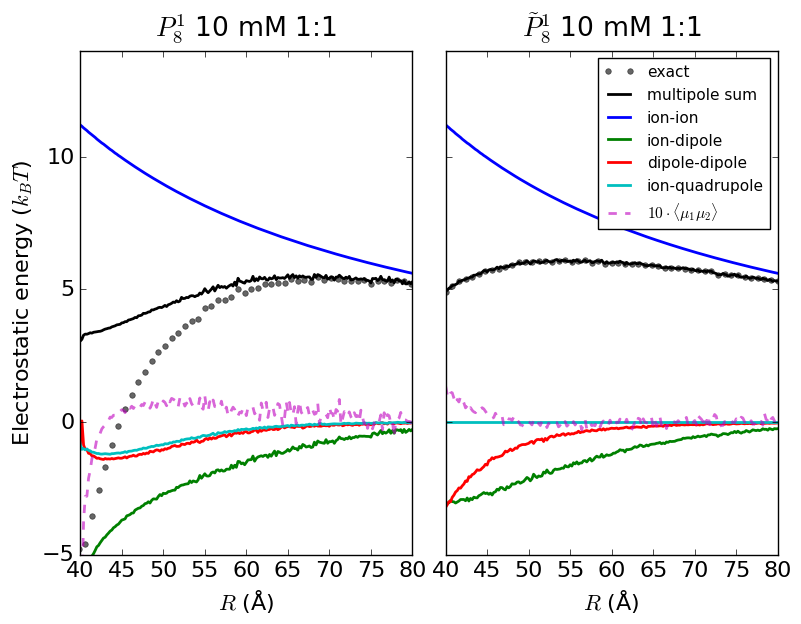

In [555]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(6.5)
f.set_figwidth(9)
plotmultipole(param[['P18-1:1-10mM']], ax=ax1, xlim=[40,80] )
plotmultipole(param[['P18-1:1-10mM-point']], ax=ax2, xlim=[40,80] )
ax2.legend(loc=0, frameon=True, fontsize='x-small', ncol=1)
ax2.set_ylabel('')
f.subplots_adjust(wspace=0.1)

plt.savefig('multipol-monovalent.pdf', bbox_inches='tight')

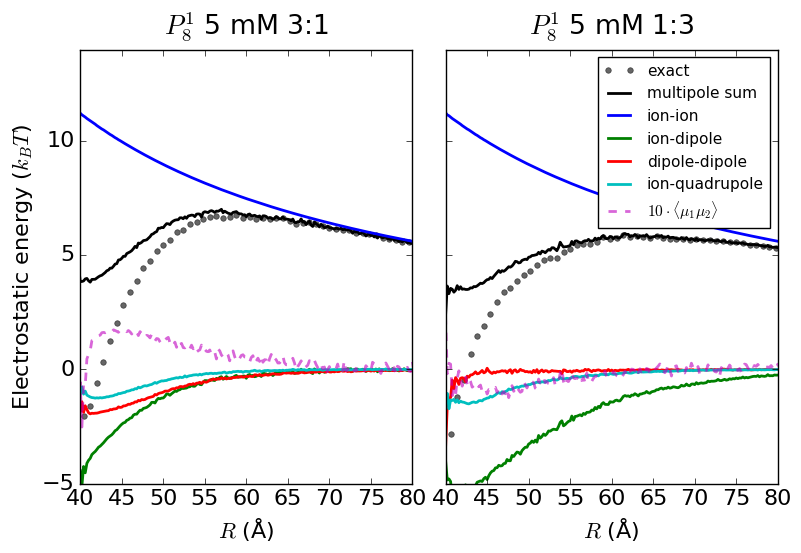

In [529]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(5.6)
f.set_figwidth(9)
plotmultipole(param[['P18-3:1-5mM']], ax=ax1, xlim=[40,80] )
plotmultipole(param[['P18-1:3-5mM']], ax=ax2, xlim=[40,80] )
ax2.legend(loc=0, frameon=True, fontsize='x-small', ncol=1)
ax2.set_ylabel('')
f.subplots_adjust(wspace=0.1)

plt.savefig('multipol-trivalent.pdf', bbox_inches='tight')

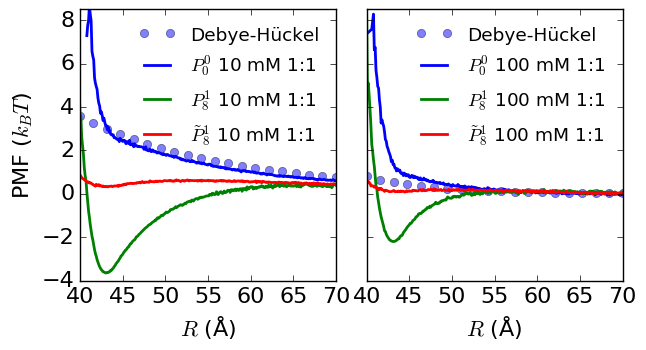

In [545]:
%cd -q $workdir/mc
def plotpmf(data, xlim, ax, shift=0, ljeps=0.2479):
    for particletype, d in data.items(): # 'P00', 'P18', ...

        ionstr = ''
        for ion, N in d.ions.items(): # loop over all ion conditions
            ionstr = ion+str(N) + ionstr

        directory = particletype
        if os.path.isdir(directory):
            %cd -q $directory

            if os.path.isfile('rdf.dat'):
                r, g = np.loadtxt('rdf.dat', unpack=True)
                g = g / g[r>80].mean()
                ax.plot(r, -np.log(g)+shift, label=d.label, lw=2)#, color=d.color)

            %cd -q ..

    ax.set_xlabel('$R$ (Å)')
    ax.set_ylabel('PMF ($k_BT$)')
    ax.set_xlim(xlim)
    ax.set_ylim((-4,8.5))

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figwidth(7)
f.set_figheight(3.5)

# Debye-Huckel
from math import sinh
r=np.linspace(40,70,20)
a=22.0 # radius

# 10 mM
D=3.04/sqrt(0.01)
QQ = (8*sinh(a/D) / (a/D))**2
#ax1.plot( r, 7*8*8/(r*(1+a/D))*np.exp(-(r-a)/D), 'bo', alpha=0.5, label=u'Debye-Hückel')
ax1.plot( r, 7*QQ/r*np.exp(-r/D), 'bo', alpha=0.5, label=u'Debye-Hückel')

# 100 mM
D=3.04/sqrt(0.1)
QQ = (8*sinh(a/D) / (a/D))**2
#ax2.plot( r, 7*8*8/(r*(1+a/D))*np.exp(-(r-a)/D), 'bo', alpha=0.5, label=u'Debye-Hückel')
ax2.plot( r, 7*QQ/r*np.exp(-r/D), 'bo', alpha=0.5, label=u'Debye-Hückel')

plotpmf(param[['P00-1:1-10mM', 'P18-1:1-10mM', 'P18-1:1-10mM-point']], ax=ax1, xlim=[40,70], shift=0.28 )
plotpmf(param[['P00-1:1-100mM', 'P18-1:1-100mM', 'P18-1:1-100mM-point']], ax=ax2, xlim=[40,70] )

ax1.legend(loc=0, frameon=False, fontsize='small', ncol=1)
ax2.legend(loc=0, frameon=False, fontsize='small', ncol=1)
ax2.set_ylabel('')
f.subplots_adjust(wspace=0.12)

plt.savefig('pmf-monovalent.pdf', bbox_inches='tight')

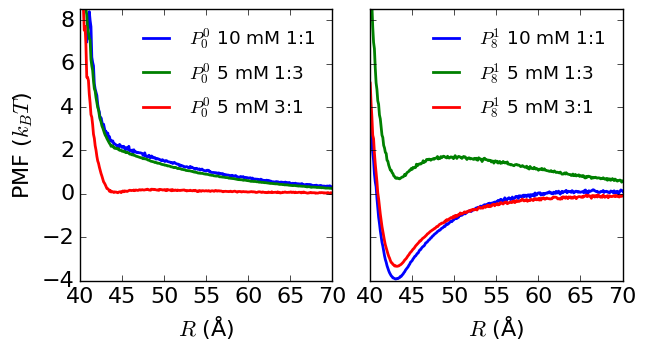

In [546]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figwidth(7)
f.set_figheight(3.5)

plotpmf(param[['P00-1:1-10mM','P00-1:3-5mM', 'P00-3:1-5mM']], ax=ax1, xlim=[40,70] )
plotpmf(param[['P18-1:1-10mM','P18-1:3-5mM', 'P18-3:1-5mM']], ax=ax2, xlim=[40,70] )

ax1.legend(loc=0, frameon=False, fontsize='small')
ax2.legend(loc=0, frameon=False, fontsize='small')
ax2.set_ylabel('')

f.subplots_adjust(wspace=0.15)

plt.savefig('pmf-trivalent.pdf', bbox_inches='tight')